<a href="https://colab.research.google.com/github/RegaipKURT/Machine-Learning-Python/blob/master/Auto_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [0]:
!pip3 install arch yfinance pmdarima

In [0]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Loading the data

In [14]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2020-01-29", 
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [0]:
df_comp = raw_data.copy()

In [0]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [0]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

### Creating Returns

In [0]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

### Splitting the Data

In [0]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Fitting a Model

In [0]:
from pmdarima.arima import auto_arima

In [0]:
model_auto = auto_arima(df.ret_ftse[1:])

In [22]:
model_auto

ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 5), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [23]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5437
Model:               SARIMAX(3, 0, 5)   Log Likelihood               -8407.476
Date:                Wed, 01 Apr 2020   AIC                          16834.952
Time:                        23:33:41   BIC                          16900.962
Sample:                             0   HQIC                         16857.989
                               - 5437                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0434      0.033      1.313      0.189      -0.021       0.108
ar.L1         -0.1416      0.076     -1.868      0.062      -0.290       0.007
ar.L2         -0.8812      0.018    -49.037      0.000      -0.916      -0.846
ar.L3         -0.2957      0.070     -4.204      0.000      -0.433      -0.158
ma.L1          0.1170      0.076      1.540      0.124      -0.032       0.266
ma.L2          0.8284      0.021     39.405      0.000       0.787       0.870
ma.L3          0.1869      0.069      2.705      0.007       0.052       0.322
ma.L4         -0.0114      0.009     -1.305      0.192      -0.029       0.006
ma.L5         -0.1066      0.008    -13.220      0.000      -0.122      -0.091
sigma2         1.2901      0.013     95.845      0.000       1.264       1.316
===================================================================================
Ljung-Box (Q):                       74.44   Jarque-Bera (JB):              7327.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Important Arguments

In [0]:
model_auto = auto_arima(df_comp.ret_ftse[1:], exogenous = df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m = 5,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(df_comp)*0.2))

# !!! Important Note: In pdmarima v1.5.2, out_of_sample_size is replaced with out_of_sample, so make sure to use the latter!

# exogenous -> outside factors (e.g other time series)
# m -> seasonal cycle length
# max_order -> maximum amount of variables to be used in the regression (p + q)
# max_p -> maximum AR components
# max_q -> maximum MA components
# max_d -> maximum Integrations
# maxiter -> maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)
# alpha -> level of significance, default is 5%, which we should be using most of the time
# n_jobs -> how many models to fit at a time (-1 indicates "as many as possible")
# trend -> "ct" usually
# information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
#        (Akaike Information Criterion, Corrected Akaike Information Criterion,
#        Bayesian Information Criterion, Hannan-Quinn Information Criterion, or
#        "out of bag"--for validation scoring--respectively)
# out_of_smaple -> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

In [25]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6797
Model:             SARIMAX(2, 0, 2)x(1, 0, 1, 5)   Log Likelihood               -6753.825
Date:                           Wed, 01 Apr 2020   AIC                          13531.650
Time:                                   23:38:36   BIC                          13613.541
Sample:                               01-11-1994   HQIC                         13559.910
                                    - 01-29-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0051      0.007     -0.702      0.482      -0.019       0.009
drift      -1.079e-06   2.12e-06     -0.508      0.611   -5.24e-06    3.08e-06
ret_spx        0.0926      0.005     17.133      0.000       0.082       0.103
ret_dax        0.5598      0.005    118.893      0.000       0.551       0.569
ret_nikkei     0.0698      0.004     17.135      0.000       0.062       0.078
ar.L1         -0.1593      0.098     -1.631      0.103      -0.351       0.032
ar.L2          0.5318      0.057      9.376      0.000       0.421       0.643
ma.L1          0.0590      0.098      0.603      0.547      -0.133       0.251
ma.L2         -0.5564      0.055    -10.044      0.000      -0.665      -0.448
ar.S.L5        0.0751      0.315      0.238      0.812      -0.542       0.692
ma.S.L5       -0.1043      0.315     -0.331      0.741      -0.722       0.513
sigma2         0.4259      0.004    103.313      0.000       0.418       0.434
===================================================================================
Ljung-Box (Q):                       86.14   Jarque-Bera (JB):             16744.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

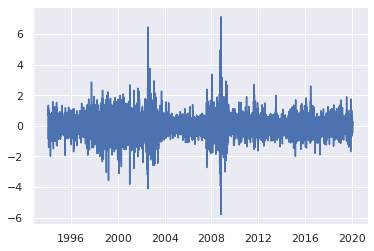

In [28]:
plt.plot(model_auto.resid())
plt.show()